# GEOCLIM Parameter Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from tqdm import tqdm_notebook

from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

from scipy import stats
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## Functions

In [2]:
def extract_basin_variables(param_nc):
    """
    Get data for each basin in the basin mask.
    
    Parameters
    ----------
    param_nc : netCDF dataset
        netCDF output from the parameter exploration routine.
    
    Returns
    -------
    basin_model_df : dataframe
        Contains the t(CaMgNaK)/yr/km2 for each basin.
        
    total_CO2_consumption : array
        Total CO2 consumption (mol/yr) for each run.
        
    WSI : array
        weathering saturation index for each run.
    """
    n_runs = len(param_nc.variables['parameterization'])
    n_basins = len(basin_data['basin'])
    
    # get area map - units: m2
    area_map = param_nc.variables['area'][:,:].data.copy()
    area_map[np.isnan(area_map)] = 0
    area_map[area_map > 1e30] = 0
    
    # get lith map
    lith_map = param_nc.variables['litho_mask'][:,:]
    
    # get erosion map
    eros_map = param_nc.variables['erosion'][:,:].data.copy()
    eros_map[np.isnan(eros_map)] = 0
    eros_map[eros_map > 1e30] = 0
    
    # total erosion
    Etot = np.nansum(area_map * eros_map)
    
    # storage array
    basin_model = np.zeros((n_runs, n_basins))
    total_CO2_consumption = np.zeros(n_runs)
    WSI = np.zeros(n_runs)
    
    # loop over each parameter run
    for i in tqdm_notebook(range(n_runs), desc='run loop'):
        
        # get CO2 consumption map - units: mol(CaMg)/m2/yr
        CaMg_map = param_nc.variables['weathering'][i,:,:].data.copy()
        CaMg_map[np.isnan(CaMg_map)] = 0
        CaMg_map[CaMg_map > 1e30] = 0
        
        # convert CO2 consumption map from mol(CaMg)/m2/yr to mol(CaMg)/yr
        CaMg_map = CaMg_map * area_map
        
        # get total CO2 consumption
        total_CO2_consumption[i] = np.nansum(CaMg_map)
        
        # Weathering Saturation Index (WSI)
        lith_comp = param_nc.variables['CaMg'][i,:]
        CaMg_bedrock_map = lith_comp[lith_map-1]            
        WSI[i] = np.ma.sum( CaMg_map/CaMg_bedrock_map ) / Etot
        
        # loop over each basin
        for j in range(n_basins):
            
            # pull out the basin mask
            this_basin_mask = basin_mask.variables[basin_data['basin'][j]][:,:].data.copy()

            # convert NaNs to zeros
            this_basin_mask[np.isnan(this_basin_mask)] = 0

            # get rid of fill values
            this_basin_mask[this_basin_mask > 1e35] = 0

            # convert remaining values (the basin mask) to 1
            this_basin_mask[this_basin_mask != 0] = 1
            
            # change CO2 consumption and area to 0 everywhere that isn't in the basin
            this_basin_CaMg_map = CaMg_map.copy()
            this_basin_CaMg_map[this_basin_mask!=1] = 0
            this_basin_area_map = area_map.copy()
            this_basin_area_map[this_basin_mask!=1] = 0

            # sum and store - mol(CaMg)/yr/m2
            basin_model[i, j] = np.nansum(this_basin_CaMg_map) / np.nansum(this_basin_area_map)
            
    # store as a dataframe        
    basin_model_df = pd.DataFrame(columns=basin_data['basin'], data=basin_model)
    
    # convert from mol(CaMg)/yr/m2 to t(CaMgNaK)/yr/km2
    for i in range(n_basins):
        Gaillardet1999a_row = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']==basin_names[i]]
        if len(Gaillardet1999a_row.index)!=0:
            mol_kg = Gaillardet1999a_row['silicates_Ca+Mg_sil'].values[0]/\
                     Gaillardet1999a_row['silicates_Cation_sil'].values[0]
        else:
            mol_kg = 12.5
        basin_model_df[basin_data['basin'][i]] = ((basin_model_df[basin_data['basin'][i]]/mol_kg)/1000)*1e6
    
    return basin_model_df, total_CO2_consumption, WSI

In [3]:
def get_regression_coefficient(data, model):
    """
    Calculate the regression coefficient, as in Maffre et al. (2018) Appendix C.
    
    Parameters
    ----------
    data : array
        data values
        
    model : array
        model values
    
    Returns
    -------
    r2s : array
        regression coefficient
    """
    # convert to log
    model = np.log10(model.astype(np.float64))
    data = np.log10(data.astype(np.float64))
    
    # storage array
    r2s = np.zeros(np.shape(model)[0])
    
    for i in range(len(r2s)):
    
        # calculate the fraction
        numerator = np.sum((model[i,:] - data)**2)
        denominator = np.sum((data - np.mean(data))**2)
        
        # output r2
        r2s[i] = 1 - numerator/denominator
    
    return r2s

In [4]:
def get_params(param_nc):
    """
    Get the parameters out of the netCDF and into a pandas dataframe.
    
    Parameters
    ----------
    param_nc : netCDF dataset
        netCDF output from the parameter exploration routine.
        
    Returns
    -------
    params : dataframe
        parameters extracted from the netCDF output.
    """
    
    params_cols = ['Ea_rp',
                   'T0_rp',
                   'Ea',
                   'T0',
                   'krp',
                   'h0',
                   'ke',
                   'a',
                   'b',
                   'Kwest',
                   'kw',
                   'sigma']
    
    params = pd.DataFrame(columns=params_cols)
    
    for i in range(len(params_cols)):
        col_vals = param_nc.variables[params_cols[i]][:].data
        params[params_cols[i]] = col_vals
        
    params['CaMg_1'] = param_nc.variables['CaMg'][:,0].data
    params['CaMg_2'] = param_nc.variables['CaMg'][:,1].data
    params['CaMg_3'] = param_nc.variables['CaMg'][:,2].data
    params['CaMg_4'] = param_nc.variables['CaMg'][:,3].data
    params['CaMg_5'] = param_nc.variables['CaMg'][:,4].data
    params['CaMg_6'] = param_nc.variables['CaMg'][:,5].data
    
    params['litho_kin_factor_1'] = param_nc.variables['litho_kin_factor'][:,0].data
    params['litho_kin_factor_2'] = param_nc.variables['litho_kin_factor'][:,1].data
    params['litho_kin_factor_3'] = param_nc.variables['litho_kin_factor'][:,2].data
    params['litho_kin_factor_4'] = param_nc.variables['litho_kin_factor'][:,3].data
    params['litho_kin_factor_5'] = param_nc.variables['litho_kin_factor'][:,4].data
    params['litho_kin_factor_6'] = param_nc.variables['litho_kin_factor'][:,5].data
    
    return params

In [5]:
def correlation_matrix(dataframe):
    """
    Plot a correlation matrix.
    
    Parameters
    ----------
    dataframe : dataframe
        Contains the variables.
    """
    # calculate the correlation matrix
    corr_mtx = np.corrcoef(np.transpose(dataframe.values))

    fig, ax = plt.subplots(figsize=(10,8))

    # plot the colours
    cax = ax.imshow(corr_mtx, vmin=-1, vmax=1, cmap='RdYlGn')

    # set the axis labels
    ax.set_xticks(np.arange(0,len(dataframe.columns)))
    ax.set_yticks(np.arange(0,len(dataframe.columns)))
    ax.set_xticklabels(dataframe.columns, rotation=90)
    ax.set_yticklabels(dataframe.columns)

    # add the colorbar
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
    cbar.ax.set_ylabel('correlation coefficient', rotation=270)

    # add text for the values
    for i in range(len(dataframe.columns)):
        for j in range(len(dataframe.columns)):
            ax.text(i, j, str(np.round(corr_mtx[i,j],2)),
                    horizontalalignment='center', verticalalignment='center')

    plt.show(fig)

## Basin Data

Get the files:

In [6]:
drive_path = '../../../Google Drive/Paleogeo_GEOCLIM/'

basin_mask = Dataset(drive_path+'GEOCLIM_Output/weathering_basins/riverbasin_Gaillardet+HYBAM-NEW.nc')
basin_data_nc = Dataset(drive_path+'GEOCLIM_Output/weathering_basins/weathering_Gaillardet+HYBAM_2.nc')

Gaillardet1999a_Table3 = pd.read_csv(drive_path+'GEOCLIM_Output/weathering_basins/Gaillardet1999a_Table3.csv')
Gaillardet1999a_Table3 = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']!='World average']

Extract the data for each basin:

In [7]:
# pull out the basin names
basin_names = []
for i in range(len(basin_data_nc.variables['basin'].ncattrs())):
    basin_names.append(getattr(basin_data_nc.variables['basin'], basin_data_nc.variables['basin'].ncattrs()[i]))
    
# create the dataframe
basin_data = pd.DataFrame({'basin':basin_names,
                           'area':basin_data_nc.variables['area'][:].data,
                           'discharge':basin_data_nc.variables['discharge'][:].data,
                           'CaMgNaK_sil':basin_data_nc.variables['cation_sil'][:].data})

# get rid of fill values
basin_data.loc[basin_data['area']>1e36, 'area'] = np.nan
basin_data.loc[basin_data['discharge']>1e36, 'discharge'] = np.nan
basin_data.loc[basin_data['CaMgNaK_sil']>1e36, 'CaMgNaK_sil'] = np.nan

# get rid of those basins without cation data
basin_data = basin_data[np.isfinite(basin_data['CaMgNaK_sil'])]

# get rid of the Don River and VGR (as per Maffre et al., 2018 Appendix B)
basin_data = basin_data[basin_data['basin']!='Don']
basin_data = basin_data[basin_data['basin']!='VGR']
basin_data.reset_index(drop=True, inplace=True)

# add Esmeraldas from HYBAM data .csv
basin_data.loc[basin_data.index.max()+1] = ['esmeraldas', 19000, 857e-9*60*60*24*365.25, (20.2/1e6)*19000]

# get the basin names again, before they get altered below
basin_names = basin_data['basin'].to_list()

# make it match the spelling in Gaillardet et al. (1999) Table 3
for i in range(len(basin_names)):
    basin_names[i] = basin_names[i].replace('Yenissei', 'Yenisei')
    basin_names[i] = basin_names[i].replace('Congo', 'Congo-Zaire')
    basin_names[i] = basin_names[i].replace('Huang He', 'Huanghe')
    basin_names[i] = basin_names[i].replace('Shatt el arab', 'Shatt el Arab')
    basin_names[i] = basin_names[i].replace('Yenissei', 'Yenisei')
    
# get silicate Ca+Mg (for HYBAM, use 12.5 mol/kg)
mean_mol_kg = 12.5
for i in range(len(basin_names)):
    Gaillardet1999a_row = Gaillardet1999a_Table3[Gaillardet1999a_Table3['Basins']==basin_names[i]]
    if len(Gaillardet1999a_row.index)!=0:
        basin_data.loc[i,'CaMg_sil'] = Gaillardet1999a_row['silicates_Ca+Mg_sil'].values[0]
    else:
        basin_data.loc[i,'CaMg_sil'] = (basin_data['CaMgNaK_sil'][i]*1e6*1e3 * mean_mol_kg) / 1e9

# change basin names to match the formatting (and typos) in the basin mask
for i in range(49):
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].lower()
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('.', '')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace(' ', '_')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('huang_he', 'huanghe')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('hong_he', 'honghe')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('congo-zaire', 'congo')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('murray_darling', 'murray')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('yenisei', 'yenissei')
    basin_data.loc[i, 'basin'] = basin_data['basin'][i].replace('kuskokwin', 'kuskowin')
    
# convert units of CaMgNaK_sil from Mt/yr to t/yr
basin_data['CaMgNaK_sil'] = basin_data['CaMgNaK_sil'] * 1e6

# store the source of the data
for i in range(len(basin_data.index)):
    if i <= 48:
        basin_data.loc[i, 'source'] = 'Gaillardet et al. (1999)'
    elif i <= 75:
        basin_data.loc[i, 'source'] = 'HYBAM Amazon'
    else:
        basin_data.loc[i, 'source'] = 'HYBAM Pacific'
        
# normalize to area
basin_data['CaMg_sil_norm'] = basin_data['CaMg_sil'] / basin_data['area']
basin_data['CaMgNaK_sil_norm'] = basin_data['CaMgNaK_sil'] / basin_data['area']

print('units:')
print('')
print('area        = km2')
print('discharge   = km3/yr')
print('CaMgNaK_sil = t/yr Ca+Mg+Na+K')
print('CaMg_sil    = 1e9 mol/yr Ca+Mg')

basin_data

units:

area        = km2
discharge   = km3/yr
CaMgNaK_sil = t/yr Ca+Mg+Na+K
CaMg_sil    = 1e9 mol/yr Ca+Mg


,basin,area,discharge,CaMgNaK_sil,CaMg_sil,source,CaMg_sil_norm,CaMgNaK_sil_norm
0,amazon,6112000.0,6590.000000,1.320000e+07,128.000000,Gaillardet et al. (1999),0.000021,2.159686
1,changjiang,1808000.0,928.000000,2.500000e+06,29.000000,Gaillardet et al. (1999),0.000016,1.382743
2,mississippi,2980000.0,580.000000,5.100000e+06,60.000000,Gaillardet et al. (1999),0.000020,1.711409
3,irrawady,410000.0,486.000000,1.710000e+07,165.000000,Gaillardet et al. (1999),0.000402,41.707318
4,ganges,1630000.0,1003.000000,9.800000e+06,130.000000,Gaillardet et al. (1999),0.000080,6.012270
5,yenissei,2590000.0,620.000000,3.200000e+06,30.000000,Gaillardet et al. (1999),0.000012,1.235521
6,mackenzie,1787000.0,308.000000,1.600000e+06,19.000000,Gaillardet et al. (1999),0.000011,0.895355
7,st_lawrence,1020000.0,337.000000,8.000000e+05,9.000000,Gaillardet et al. (1999),0.000009,0.784314
8,lena,2490000.0,525.000000,1.700000e+06,19.000000,Gaillardet et al. (1999),0.000008,0.682731
9,xijiang,437000.0,363.000000,7.000000e+05,9.000000,Gaillardet et al. (1999),0.000021,1.601831


## GEOCLIM Output

Get the files:

In [8]:
param_explor_path = '../../GEOCLIM/preproc/dynsoil/param_explor/'

param_nc = Dataset(drive_path+'GEOCLIM_Output/parameter_exploration_1.nc')
param_nc.variables.keys()

odict_keys(['lon', 'lat', 'lithology', 'parameterization', 'area', 'litho_mask', 'reg_thickness', 'erosion', 'weathering', 'Ea_rp', 'T0_rp', 'Ea', 'T0', 'krp', 'h0', 'ke', 'a', 'b', 'Kwest', 'kw', 'sigma', 'CaMg', 'litho_kin_factor'])

In [9]:
print('number of runs: {}'.format(len(param_nc.variables['parameterization'])))

number of runs: 10800


Get the parameters out of the netCDF:

In [10]:
params = get_params(param_nc)

Get the silicate weathering for each basin for each run, in t/km$^{2}$/yr of Ca+Mg+Na+K:

In [11]:
refresh = False

if refresh:
    basin_model, total_CO2_consumption, WSI = extract_basin_variables(param_nc)
    basin_model.to_csv('basin_model.csv', index=False)
    np.savetxt('total_CO2_consumption.csv', total_CO2_consumption, delimiter=',')
    np.savetxt('WSI.csv', WSI, delimiter=',')
else:
    basin_model = pd.read_csv('basin_model.csv')
    total_CO2_consumption = np.loadtxt('total_CO2_consumption.csv', delimiter=',')
    WSI = np.loadtxt('WSI.csv', delimiter=',')

In [12]:
basin_model.head()

,amazon,changjiang,mississippi,irrawady,ganges,yenissei,mackenzie,st_lawrence,lena,xijiang,ob,parana,mekong,congo,rhine,yukon,orinoco,magdalena,columbia,indus,nelson,n_dvina,amur,huanghe,rhone,shatt_el_arab,honghe,po,fly,tocantins,dnepr,sepik,nile,narmada,murray,purari,fraser,kolima,krishna,pechora,niger,uruguay,kuskowin,cauveri,zambese,khatanga,seine,kikori,limpopo,ABA,ALT,ATA,BEL,BOR,CAI,CAR,CHA,DJI,FOR,GUA,ITA,JHE,LAB,MAN,MIR,NLO,NRO,NYO,PCH,PSI,PUN,PVI,RUR,SAN,SEB,SER,canete,ocona,santa,tumbes,esmeraldas
0,0.007075,0.000550,0.000194,0.004221,0.002019,0.000169,0.000052,0.000587,0.000022,0.001379,0.000049,0.001295,0.002011,0.001813,0.000398,0.000057,0.008320,0.004941,0.000835,0.000206,0.000105,0.000103,0.000048,0.000022,0.000262,0.000208,0.000701,0.000820,0.002383,0.005158,0.000051,0.002601,0.000387,0.016047,0.000049,0.000366,0.000675,0.000006,0.025150,0.000059,0.001192,0.007152,0.000063,0.005305,0.000210,0.000044,0.000064,0.003124,0.000298,0.000136,0.006969,0.001580,0.007185,0.001380,0.020792,0.003345,0.002403,0.003741,0.006028,0.004017,0.005882,0.004589,0.005018,0.005713,0.002193,0.005258,0.007142,0.006806,0.002339,0.001471,0.002717,0.000794,0.000669,0.002486,0.004520,0.011086,0.000667,0.000401,0.000210,0.001919,0.002691
1,0.010445,0.000935,0.000358,0.007640,0.003109,0.000184,0.000072,0.000661,0.000025,0.002004,0.000089,0.001495,0.003522,0.002466,0.000735,0.000071,0.010090,0.006362,0.000873,0.000310,0.000112,0.000206,0.000063,0.000043,0.000496,0.000284,0.001402,0.001227,0.004766,0.006365,0.000094,0.004503,0.000404,0.016330,0.000071,0.000733,0.000703,0.000009,0.025196,0.000119,0.001333,0.007325,0.000126,0.005400,0.000271,0.000055,0.000128,0.006248,0.000344,0.000273,0.007969,0.002307,0.014370,0.002501,0.021538,0.006689,0.004584,0.006835,0.011489,0.005880,0.007528,0.008788,0.008575,0.010768,0.004386,0.010254,0.014283,0.013612,0.004678,0.002820,0.004786,0.001587,0.001338,0.003618,0.007294,0.014251,0.000667,0.000442,0.000419,0.002036,0.003809
2,0.013815,0.001319,0.000523,0.011059,0.004199,0.000199,0.000093,0.000736,0.000027,0.002629,0.000129,0.001695,0.005034,0.003119,0.001072,0.000085,0.011859,0.007783,0.000911,0.000414,0.000119,0.000310,0.000078,0.000064,0.000730,0.000360,0.002103,0.001633,0.007149,0.007571,0.000138,0.006406,0.000420,0.016613,0.000093,0.001099,0.000732,0.000013,0.025242,0.000178,0.001475,0.007498,0.000189,0.005495,0.000331,0.000067,0.000193,0.009372,0.000390,0.000409,0.008969,0.003034,0.021555,0.003622,0.022283,0.010034,0.006765,0.009928,0.016949,0.007744,0.009174,0.012988,0.012132,0.015823,0.006579,0.015249,0.021425,0.020418,0.007016,0.004170,0.006855,0.002381,0.002007,0.004750,0.010068,0.017416,0.000667,0.000484,0.000629,0.002153,0.004928
3,0.017186,0.001704,0.000688,0.014477,0.005289,0.000215,0.000114,0.000811,0.000030,0.003254,0.000169,0.001895,0.006546,0.003772,0.001409,0.000100,0.013629,0.009204,0.000949,0.000518,0.000126,0.000413,0.000094,0.000085,0.000964,0.000436,0.002804,0.002040,0.009531,0.008777,0.000181,0.008308,0.000437,0.016897,0.000115,0.001466,0.000760,0.000017,0.025288,0.000238,0.001616,0.007671,0.000251,0.005589,0.000392,0.000078,0.000257,0.012496,0.000436,0.000546,0.009968,0.003761,0.028739,0.004744,0.023029,0.013379,0.008947,0.013022,0.022409,0.009608,0.010820,0.017187,0.015689,0.020878,0.008772,0.020244,0.028566,0.027223,0.009355,0.005520,0.008924,0.003175,0.002676,0.005882,0.012843,0.020581,0.000667,0.000525,0.000838,0.002271,0.006046
4,0.020556,0.002088,0.000853,0.017896,0.006379,0.000230,0.000134,0.000886,0.000033,0.003879,0.000209,0.002094,0.008058,0.004425,0.001746,0.000114,0.015399,0.010625,0.000987,0.000621,0.000133,0.000516,0.000109,0.000106,0.001198,0.000512,0.003505,0.002447,0.011914,0.009984,0.000224,0.010210,0.000453,0.017180,0.000136,0.001832,0.000788,0.000021,0.025334,0.000297,0.001758,0.007845,0.000314,0.005684,0.000453,0.000089,0.000321,0.015620,0.000482,0.000682,0.010968,0.004488,0.035924,0.005865,0.023774,0.016724,0.011128,0.016115,0.027869,0.011472,0.012466,0.021387,0.

In [13]:
basin_model.tail()

,amazon,changjiang,mississippi,irrawady,ganges,yenissei,mackenzie,st_lawrence,lena,xijiang,ob,parana,mekong,congo,rhine,yukon,orinoco,magdalena,columbia,indus,nelson,n_dvina,amur,huanghe,rhone,shatt_el_arab,honghe,po,fly,tocantins,dnepr,sepik,nile,narmada,murray,purari,fraser,kolima,krishna,pechora,niger,uruguay,kuskowin,cauveri,zambese,khatanga,seine,kikori,limpopo,ABA,ALT,ATA,BEL,BOR,CAI,CAR,CHA,DJI,FOR,GUA,ITA,JHE,LAB,MAN,MIR,NLO,NRO,NYO,PCH,PSI,PUN,PVI,RUR,SAN,SEB,SER,canete,ocona,santa,tumbes,esmeraldas
10795,8.876902,5.846420,1.231114,32.828630,12.148057,4.076693,0.913859,9.717090,0.542986,6.987784,0.895289,3.998844,10.074358,7.526267,3.998905,1.203236,13.278043,30.694953,16.129879,1.701851,0.681388,1.148369,1.125915,0.630584,3.961600,2.854741,13.032747,19.491870,2.359152,8.160711,0.346238,4.471294,3.943129,30.218360,0.462554,7.509023,8.911006,0.255583,14.772845,1.045136,4.770727,16.509235,1.233707,25.059454,2.491918,1.794209,0.392339,2.246249,2.053098,5.639228,6.647724,24.208703,4.666789,22.179933,21.561368,2.088538,18.536189,33.808725,29.475245,2.464279,4.593475,13.249376,2.352992,4.647935,6.919626,38.209519,17.189825,2.054936,3.004892,3.203031,27.234862,7.166572,7.558911,27.434762,73.089199,4.727426,21.573732,17.751212,16.927797,17.754054,61.661415
10796,10.459446,8.010773,1.699657,42.507664,13.815354,4.257252,1.246947,10.093387,0.593594,9.987456,1.242524,4.350068,13.989969,8.212910,5.360109,1.370291,15.265021,35.716338,16.841059,1.993737,0.752513,1.722554,1.309155,0.896681,5.529018,3.408348,19.549121,21.878391,3.538728,9.059871,0.510135,6.446967,3.983164,31.581432,0.555991,11.263536,9.892796,0.346392,14.971750,1.567705,4.862276,17.003870,1.850561,25.064915,2.685725,1.992824,0.588508,3.369373,2.200824,8.458841,7.101808,27.243860,7.000183,28.639593,21.911376,3.132807,23.322480,40.781140,36.733506,2.942074,5.541603,15.268058,3.251625,5.366037,10.379440,44.681568,25.784738,3.082404,4.507338,4.743801,30.918069,10.749856,11.338367,32.192225,78.216066,5.029689,21.573732,19.108900,25.391693,19.535890,65.776453
10797,12.041991,10.175127,2.168200,52.186696,15.482654,4.437811,1.580036,10.469684,0.644202,12.987126,1.589760,4.701291,17.905580,8.899551,6.721312,1.537347,17.251995,40.737723,17.552237,2.285624,0.823638,2.296738,1.492394,1.162779,7.096437,3.961955,26.065494,24.264908,4.718304,9.959033,0.674031,8.422639,4.023199,32.944501,0.649428,15.018046,10.874586,0.437201,15.170656,2.090272,4.953824,17.498507,2.467415,25.070379,2.879532,2.191440,0.784677,4.492498,2.348550,11.278455,7.555893,30.279014,9.333578,35.099256,22.261381,4.177077,28.108773,47.753553,43.991766,3.419870,6.489732,17.286739,4.150259,6.084138,13.839252,51.153617,34.379649,4.109872,6.009784,6.284571,34.601278,14.333143,15.117822,36.949692,83.342943,5.331953,21.573732,20.466590,33.855593,21.317728,69.891491
10798,13.624535,12.339479,2.636743,61.865733,17.149949,4.618371,1.913124,10.845981,0.694810,15.986798,1.936995,5.052514,21.821192,9.586193,8.082517,1.704402,19.238973,45.759103,18.263417,2.577510,0.894763,2.870923,1.675634,1.428876,8.663855,4.515562,32.581868,26.651425,5.897880,10.858194,0.837928,10.398312,4.063234,34.307577,0.742865,18.772558,11.856375,0.528009,15.369563,2.612841,5.045373,17.993140,3.084268,25.075845,3.073339,2.390055,0.980847,5.615622,2.496277,14.098068,8.009977,33.314171,11.666973,41.558919,22.611389,5.221345,32.895067,54.725962,51.250024,3.897664,7.437860,19.305422,5.048892,6.802239,17.299066,57.625670,42.974563,5.137339,7.512230,7.825341,38.284488,17.916429,18.897276,41.707158,88.469810,5.634216,21.573732,21.824279,42.319493,23.099566,74.006524
10799,15.207080,14.503833,3.105286,71.544752,18.817250,4.798930,2.246212,11.222278,0.745418,18.986469,2.284230,5.403738,25.736803,10.272834,9.443721,1.871458,21.225948,50.780488,18.974597,2.869396,0.965888,3.445107,1.858873,1.694974,10.231274,5.069169,39.098243,29.037945,7.077457,11.757355,1.001825,12.373983,4.103270,35.670646,0.836303,22.527072,12.838165,0.618818,15.568468,3.135409,5.136922,18.487

## Model-Data Comparison

Do the regression:

In [14]:
r2s = get_regression_coefficient(basin_data['CaMgNaK_sil_norm'], basin_model.values)

Plot against total CO$_{2}$ consumption:

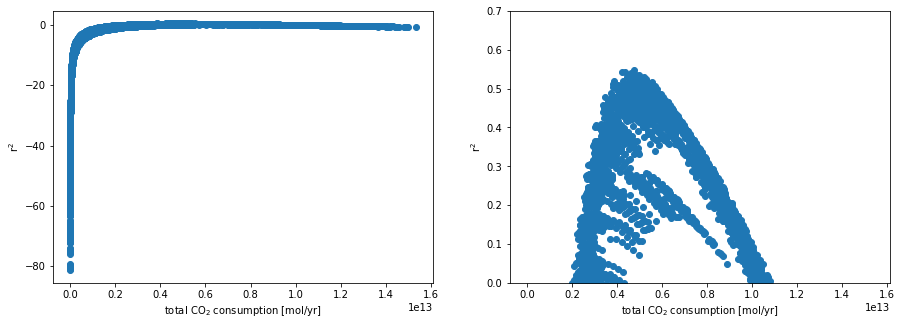

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(total_CO2_consumption, r2s)
ax[1].scatter(total_CO2_consumption, r2s)
ax[1].set_ylim(0,0.7)

ax[0].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[0].set_ylabel('r$^{2}$')

ax[1].set_xlabel('total CO$_{2}$ consumption [mol/yr]')
ax[1].set_ylabel('r$^{2}$')

plt.show(fig)

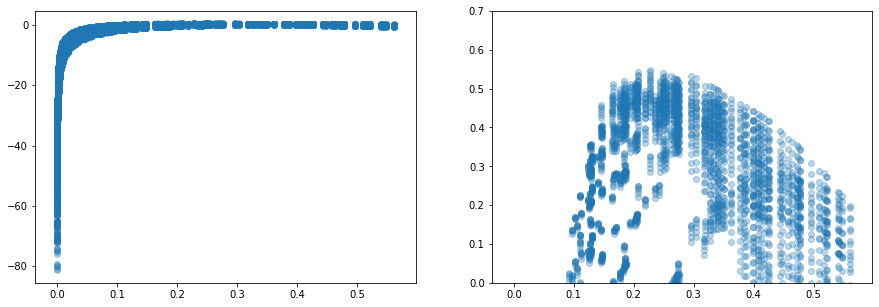

In [16]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(WSI, r2s, alpha=.3)
ax[1].scatter(WSI, r2s, alpha=.3)
ax[1].set_ylim(0,.7)

plt.show(fig)

In [17]:
print('maximum R^2 = {:.3f}'.format(np.max(r2s)))

maximum R^2 = 0.548


In [18]:
best_ind = np.argwhere(r2s == np.max(r2s))

best_Kwest = params['Kwest'][best_ind[0][0]]
best_kw = params['kw'][best_ind[0][0]]
best_sigma = params['sigma'][best_ind[0][0]]
best_CaMg_1 = params['CaMg_1'][best_ind[0][0]]
best_CaMg_6 = params['CaMg_6'][best_ind[0][0]]

print('best_Kwest = {}'.format(best_Kwest))
print('best_kw = {}'.format(best_kw))
print('best_sigma = {}'.format(best_sigma))
print('best_CaMg_1 = {}'.format(best_CaMg_1))
print('best_CaMg_6 = {}'.format(best_CaMg_6))

best_Kwest = 9.999999747378752e-05
best_kw = 1.0
best_sigma = -0.10000000149011612
best_CaMg_1 = 1500.0
best_CaMg_6 = 2500.0


Filter based on CO$_{2}$ consumption:

In [19]:
min_thresh_CO2 = 1e12
max_thresh_CO2 = 5e13

drop_inds = np.argwhere((total_CO2_consumption>max_thresh_CO2) & (total_CO2_consumption<min_thresh_CO2)).flatten()

filt_basin_model = basin_model.copy()
filt_basin_model.drop(drop_inds, inplace=True)
filt_basin_model.reset_index(inplace=True, drop=True)

filt_params = params.copy()
filt_params.drop(drop_inds, inplace=True)
filt_params.reset_index(inplace=True, drop=True)

filt_total_CO2_consumption = np.delete(total_CO2_consumption, drop_inds)

filt_r2s = np.delete(r2s, drop_inds)

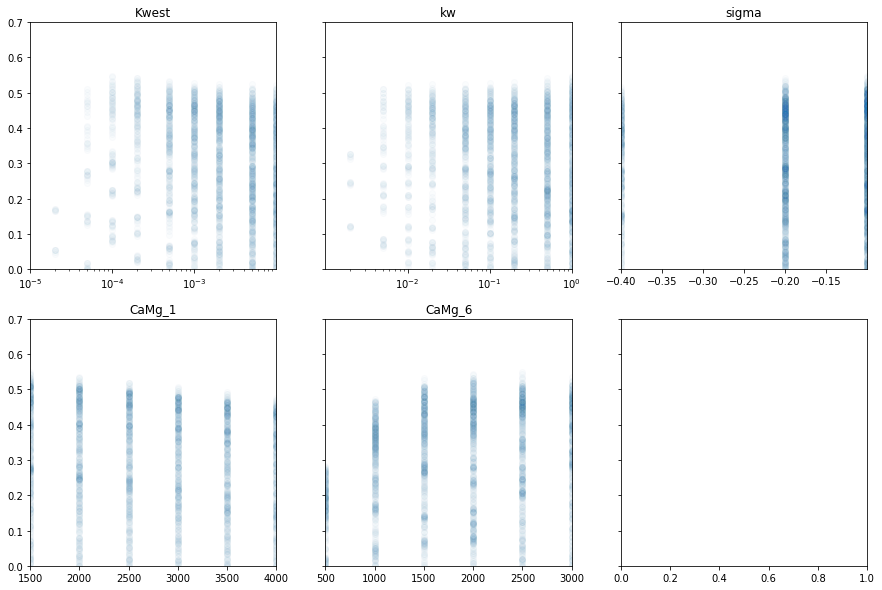

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True)

ax = ax.flatten()

alpha = 0.02

ax[0].scatter(filt_params['Kwest'], filt_r2s, alpha=alpha)
ax[0].set_xlim(np.min(filt_params['Kwest']), np.max(filt_params['Kwest']))
ax[0].set_title('Kwest')
ax[0].set_xscale('log')
ax[0].set_ylim(0,0.7)

ax[1].scatter(filt_params['kw'], filt_r2s, alpha=alpha)
ax[1].set_xlim(np.min(filt_params['kw']), np.max(filt_params['kw']))
ax[1].set_title('kw')
ax[1].set_xscale('log')

ax[2].scatter(filt_params['sigma'], filt_r2s, alpha=alpha)
ax[2].set_xlim(np.min(filt_params['sigma']), np.max(filt_params['sigma']))
ax[2].set_title('sigma')

ax[3].scatter(filt_params['CaMg_1'], filt_r2s, alpha=alpha)
ax[3].set_xlim(np.min(filt_params['CaMg_1']), np.max(filt_params['CaMg_1']))
ax[3].set_title('CaMg_1')

ax[4].scatter(filt_params['CaMg_6'], filt_r2s, alpha=alpha)
ax[4].set_xlim(np.min(filt_params['CaMg_6']), np.max(filt_params['CaMg_6']))
ax[4].set_title('CaMg_6')

plt.show(fig)

Filter based on Ca+Mg composition of metamorphics vs. sediments:

In [21]:
drop_inds = np.argwhere(filt_params['CaMg_1']<=filt_params['CaMg_6']).flatten()

filt_basin_model.drop(drop_inds, inplace=True)
filt_basin_model.reset_index(inplace=True, drop=True)

filt_params.drop(drop_inds, inplace=True)
filt_params.reset_index(inplace=True, drop=True)

filt_total_CO2_consumption = np.delete(filt_total_CO2_consumption, drop_inds)

filt_r2s = np.delete(filt_r2s, drop_inds)

/Users/hematite/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


Filter based on r$^{2}$:

In [22]:
drop_inds = np.argwhere(filt_r2s<0.4).flatten()

best_filt_basin_model = filt_basin_model.copy()
best_filt_basin_model.drop(drop_inds, inplace=True)
best_filt_basin_model.reset_index(inplace=True, drop=True)

best_filt_params = filt_params.copy()
best_filt_params.drop(drop_inds, inplace=True)
best_filt_params.reset_index(inplace=True, drop=True)

best_filt_total_CO2_consumption = np.delete(filt_total_CO2_consumption, drop_inds)

best_filt_r2s = np.delete(filt_r2s, drop_inds)

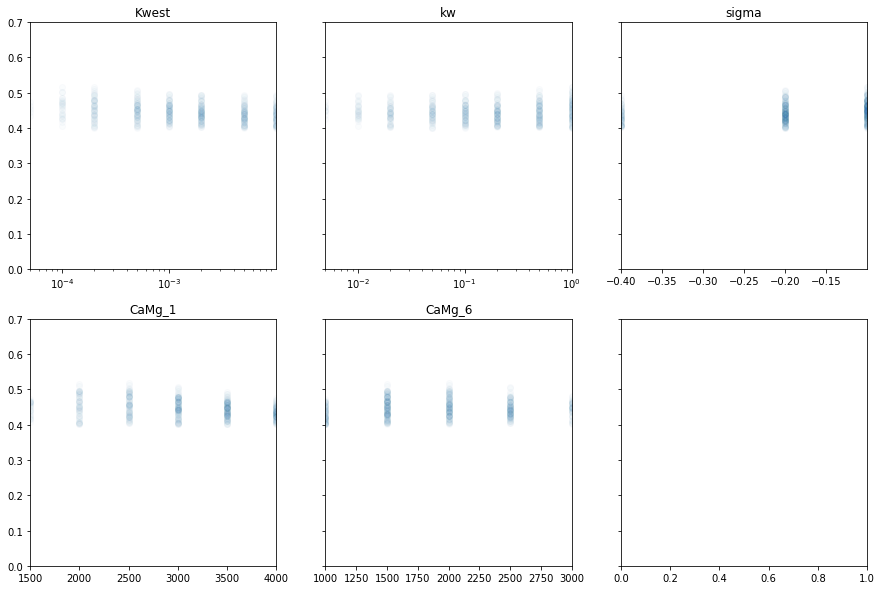

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True)

ax = ax.flatten()

alpha = 0.02

ax[0].scatter(best_filt_params['Kwest'], best_filt_r2s, alpha=alpha)
ax[0].set_xlim(np.min(best_filt_params['Kwest']), np.max(best_filt_params['Kwest']))
ax[0].set_title('Kwest')
ax[0].set_xscale('log')
ax[0].set_ylim(0,0.7)

ax[1].scatter(best_filt_params['kw'], best_filt_r2s, alpha=alpha)
ax[1].set_xlim(np.min(best_filt_params['kw']), np.max(best_filt_params['kw']))
ax[1].set_title('kw')
ax[1].set_xscale('log')

ax[2].scatter(best_filt_params['sigma'], best_filt_r2s, alpha=alpha)
ax[2].set_xlim(np.min(best_filt_params['sigma']), np.max(best_filt_params['sigma']))
ax[2].set_title('sigma')

ax[3].scatter(best_filt_params['CaMg_1'], best_filt_r2s, alpha=alpha)
ax[3].set_xlim(np.min(best_filt_params['CaMg_1']), np.max(best_filt_params['CaMg_1']))
ax[3].set_title('CaMg_1')

ax[4].scatter(best_filt_params['CaMg_6'], best_filt_r2s, alpha=alpha)
ax[4].set_xlim(np.min(best_filt_params['CaMg_6']), np.max(best_filt_params['CaMg_6']))
ax[4].set_title('CaMg_6')

plt.show(fig)

Make histograms:

[5.e-05 1.e-04 2.e-04 5.e-04 1.e-03 2.e-03 5.e-03 1.e-02]
[0.005 0.01  0.02  0.05  0.1   0.2   0.5   1.   ]
[-0.4 -0.2 -0.1]
[1500. 2000. 2500. 3000. 3500. 4000.]
[1000. 1500. 2000. 2500. 3000.]


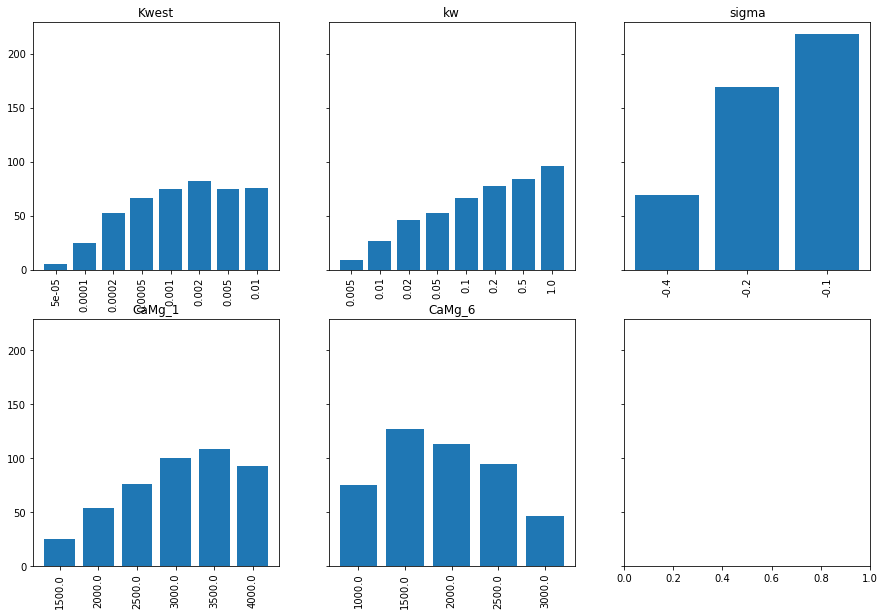

In [24]:
changing_params = ['Kwest','kw','sigma','CaMg_1','CaMg_6']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True)

ax = ax.flatten()

for i in range(len(changing_params)):
    unique_vals = np.array(best_filt_params[changing_params[i]].unique())
    unique_vals = np.sort(unique_vals)
    print(np.round(unique_vals,7))
    
    x_index = np.arange(len(unique_vals))
    y_vals = np.zeros(len(unique_vals))
    
    for j in range(len(unique_vals)):
        y_vals[j] = len(best_filt_params[best_filt_params[changing_params[i]]==unique_vals[j]])
    
    ax[i].bar(x_index,y_vals)
    
    ax[i].set_xticks(x_index)
    ax[i].set_xticklabels(np.round(unique_vals,7), rotation=90)
    
    ax[i].set_title(changing_params[i])

plt.show(fig)

Work in progress:

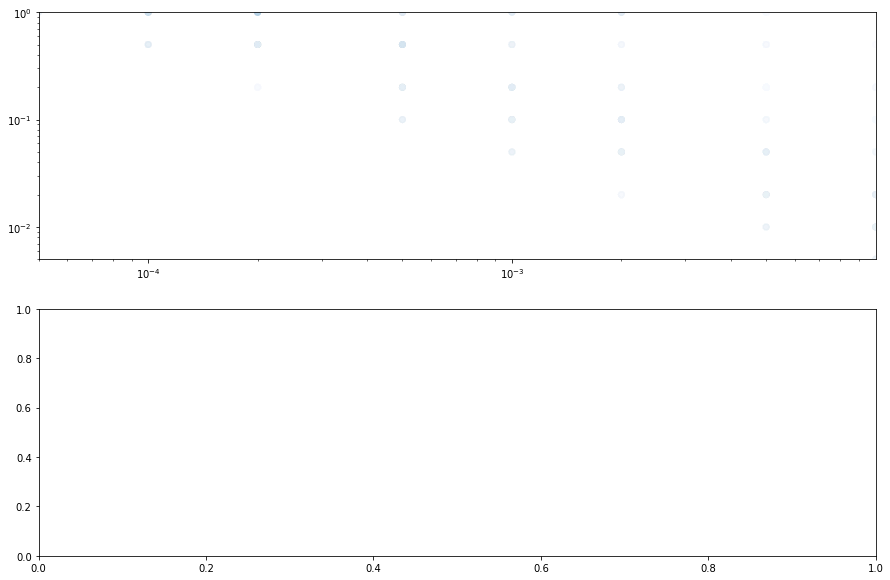

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(15,10) )

ax = ax.flatten()

ax[0].scatter( best_filt_params['Kwest'] , best_filt_params['kw'] , alpha=.1, c=best_filt_r2s, vmin=0.45, vmax=0.53, cmap='Blues')
ax[0].set_xlim(np.min(best_filt_params['Kwest']), np.max(best_filt_params['Kwest']))
ax[0].set_ylim(np.min(best_filt_params['kw']), np.max(best_filt_params['kw']))
ax[0].set_xscale('log')
ax[0].set_yscale('log')